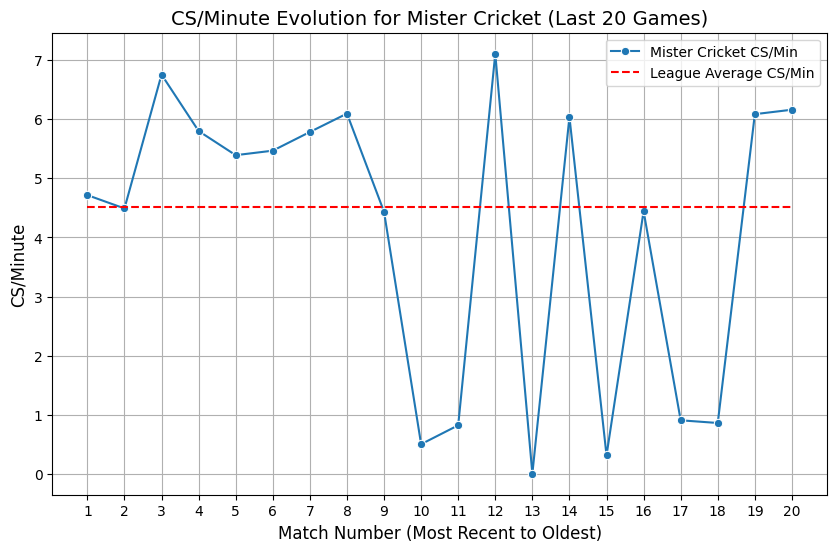

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv()

# Database connection parameters
server = '35.198.20.9'  # Replace with your GCP SQL Server public IP
port = 1433             # Default SQL Server port
database = 'RiotDB'     # Replace with your database name
username = 'sqlserver'  # Replace with your username
password = os.getenv('DB_PASSWORD')  # Retrieve password from environment variable

# Check if the password was loaded
if not password:
    raise ValueError("Database password not found. Please set the DB_PASSWORD environment variable.")

# Construct the database connection string
connection_url = (
    f"mssql+pyodbc://{username}:{password}@{server}:{port}/{database}"
    "?driver=ODBC+Driver+18+for+SQL+Server"
    "&Encrypt=yes"
    "&TrustServerCertificate=yes"
)

# Create the SQLAlchemy engine
engine = create_engine(connection_url)

# Fetch the CS/min data for the last 20 games of the summoner
def get_cs_min_data(summoner_name):
    query = f"""
    SELECT TOP 20 timePlayed, totalMinionsKilled, Match_ID 
    FROM Detalhes_Liga_Invocador
    WHERE riotIdGameName = '{summoner_name}'
    ORDER BY Match_ID DESC
    """
    df = pd.read_sql_query(query, engine)

    # Calculate CS/min for each game
    df['CS_per_Min'] = df['totalMinionsKilled'] / (df['timePlayed'] / 60)
    return df[['Match_ID', 'CS_per_Min']]

# Fetch the average CS/min for the league
def get_average_cs_min_league():
    query = """
    SELECT AVG(CAST(totalMinionsKilled AS FLOAT) / (timePlayed / 60)) AS Average_CS_per_Min
    FROM Detalhes_Liga
    WHERE timePlayed > 0
    """
    df_league = pd.read_sql_query(query, engine)
    # Fetch the average value
    return df_league['Average_CS_per_Min'].iloc[0]

# Plot the CS/min evolution for the last 20 games with the league's average CS/min as a constant
def plot_cs_min_evolution(summoner_name):
    df_cs_min = get_cs_min_data(summoner_name)
    average_cs_min_league = get_average_cs_min_league()

    # Create the line plot
    plt.figure(figsize=(10, 6))
    
    # Plot summoner's CS/min
    sns.lineplot(x=range(1, len(df_cs_min)+1), y=df_cs_min['CS_per_Min'], marker='o', label=f'{summoner_name} CS/Min')
    
    # Plot league average CS/min
    sns.lineplot(x=range(1, len(df_cs_min)+1), y=[average_cs_min_league] * len(df_cs_min), linestyle='--', color='r', label='League Average CS/Min')

    # Set the x-axis ticks to absolute numbers
    plt.xticks(ticks=range(1, len(df_cs_min)+1))

    # Add title and labels
    plt.title(f'CS/Minute Evolution for {summoner_name} (Last {len(df_cs_min)} Games)', fontsize=14)
    plt.xlabel('Match Number (Most Recent to Oldest)', fontsize=12)
    plt.ylabel('CS/Minute', fontsize=12)

    # Show the graph
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function to run the process
if __name__ == "__main__":
    # Get the desired summoner name as input
    summoner_name = input("Enter the summoner's name: ")

    # Generate and display the CS/min evolution graph
    plot_cs_min_evolution(summoner_name)
